# Identify Outliers (Deprecated)

## Prepare Data

This step is the same as the data preparation step in mds.ipynb.

In [1]:
import pandas as pd

survey_df = pd.read_csv("../data/survey.csv")
uids = list(set(survey_df["uid"]))

# Read trail data
data = pd.read_csv("../data/trial.csv")
data = data[data["uid"].isin(uids)]

# Normalize the position, the canvas size is 1000 x 600
data["x"] = data["x"] / 1000
data["y"] = data["y"] / 600

## Identify Outliers

Steps to identify outliers:
1. Generate the MDS spaces for each participant - with dimension = 3 as we found in previous notebook
2. Generate a distances vector for each participant in the MDS space
3. Compute the correlation between all pairs of distances vectors, get the mean and std.
4. Compute the average correlation coeeficient for each each participant
5. Exclude participants with average correlation `coefficient < mean - 2.5 * std`

### Step 1 & 2 - Get MDS distance vector for each participant

In [2]:
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import MDS

import numpy as np


def get_mds_vector_for_student(uid):
    distances = defaultdict(list)
    uid_data = data[data["uid"] == uid]

    for trial in range(1, 7):
        # Get data of this trial
        trial_data = uid_data[uid_data["trial_id"] == trial]
        records = trial_data.to_dict("records")

        for i in range(len(records)):
            for j in range(i + 1, len(records)):
                # Get object pair tuple, makre sure the smaller id is always first
                object_pair = (records[i]["object_id"], records[j]["object_id"])

                if object_pair[0] == object_pair[1]:
                    continue

                if object_pair[0] > object_pair[1]:
                    object_pair = (object_pair[1], object_pair[0])

                # Calculate the distance between object i and j
                p1 = np.array([records[i]["x"], records[i]["y"]])
                p2 = np.array([records[j]["x"], records[j]["y"]])
                distance = np.linalg.norm(p1 - p2)

                # Add the distance to the list
                distances[object_pair].append(distance)

    # Calculate the average distance for each object pair
    avg_distances = {
        object_pair: np.mean(distances[object_pair]) for object_pair in distances
    }

    # Sanity check to ensure we have distances for all possible objet pairs from this student
    assert len(avg_distances) == 30 * 29 / 2

    # Get the distance matrix
    distance_matrix = np.zeros((30, 30))
    for (i, j), d in avg_distances.items():
        distance_matrix[i - 1, j - 1] = d
        distance_matrix[j - 1, i - 1] = d

    # Fit into MDS space
    mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
    object_embeddings = mds.fit_transform(distance_matrix)

    # Compute pair wise distance in MDS space
    # The object pair is in sorted order
    mds_distance_vector = []
    combs = combinations(range(30), 2)
    for i, j in combs:
        p1, p2 = object_embeddings[i], object_embeddings[j]
        mds_distance_vector.append(np.linalg.norm(p1 - p2))

    # Sanity check
    assert len(mds_distance_vector) == 30 * 29 / 2

    return np.array(mds_distance_vector)

In [3]:
embedding_by_student = {uid: get_mds_vector_for_student(uid) for uid in uids}

### Step 3 - Compute average correlation

In [4]:
distance_matrix = np.array([embedding_by_student[uid] for uid in uids])

In [5]:
correlation_matrix = np.corrcoef(distance_matrix)
correlation_matrix.shape

(97, 97)

In [6]:
upper_triangle = np.triu(correlation_matrix, k=1)  # excluding diagonal
all_correlations = upper_triangle[upper_triangle != 0].flatten()
len(all_correlations)

4656

In [7]:
mean_corr = np.mean(all_correlations)
std_corr = np.std(all_correlations)
print(f"mean: {mean_corr}, std: {std_corr}")

mean: 0.07281097759676572, std: 0.0887362846376122


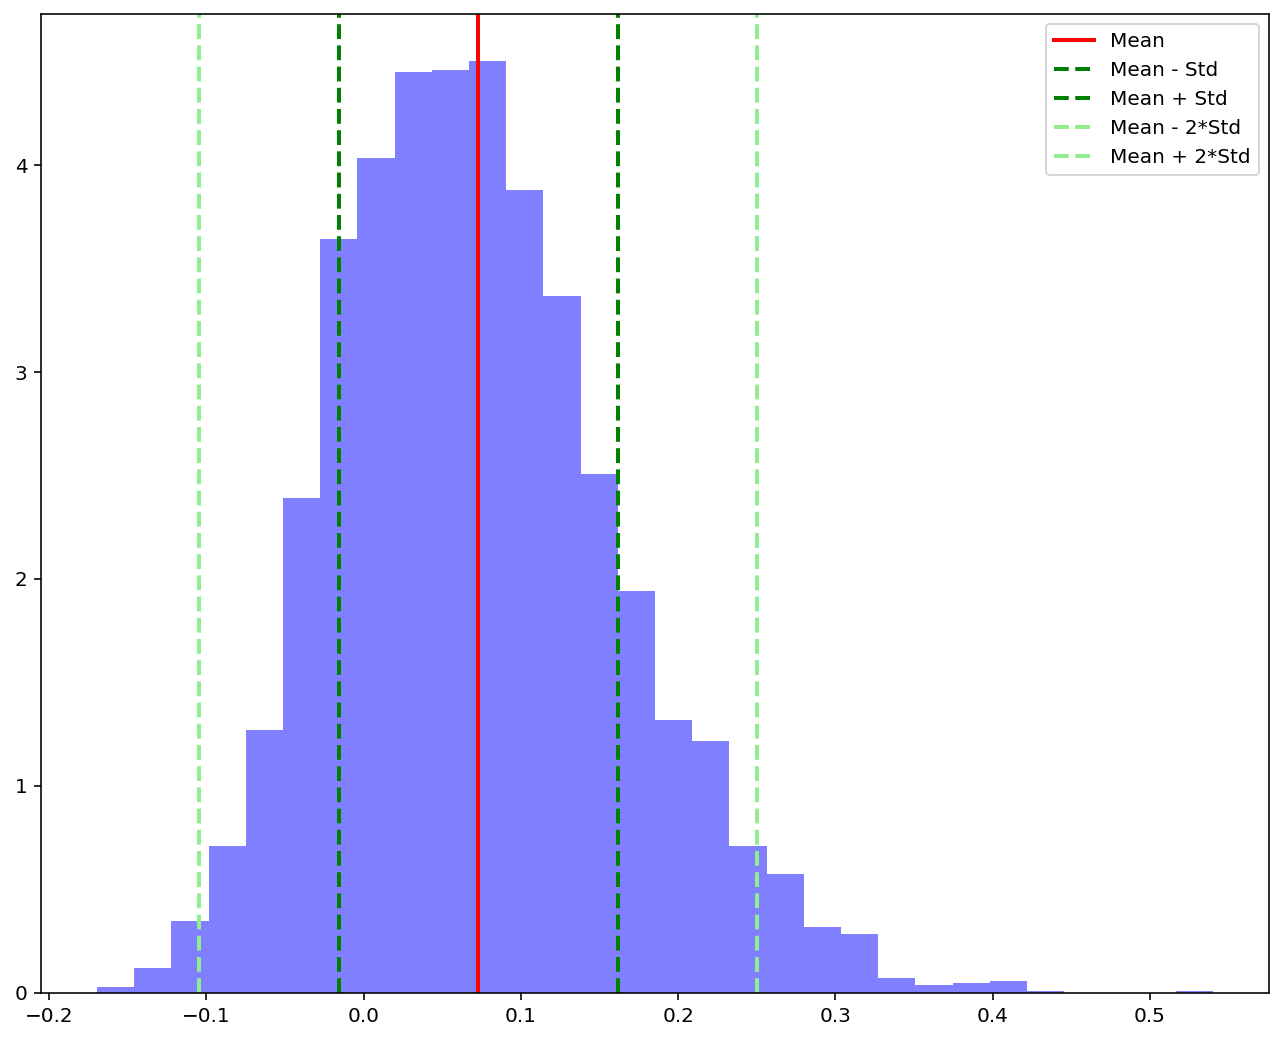

In [8]:
import matplotlib.pyplot as plt

# Setup inline and retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set up the matplotlib figure
plt.subplots(figsize=(11, 9))

# Plot vertical lines for mean, mean - std, and mean + std
# Plot the histogram
plt.hist(all_correlations, bins=30, density=True, alpha=0.5, color='blue')

plt.axvline(mean_corr, color='red', linewidth=2, label='Mean')
plt.axvline(mean_corr - std_corr, color='green', linestyle='dashed', linewidth=2, label='Mean - Std')
plt.axvline(mean_corr + std_corr, color='green', linestyle='dashed', linewidth=2, label='Mean + Std')
plt.axvline(mean_corr - 2 * std_corr, color='lightgreen', linestyle='dashed', linewidth=2, label='Mean - 2*Std')
plt.axvline(mean_corr + 2 * std_corr, color='lightgreen', linestyle='dashed', linewidth=2, label='Mean + 2*Std')

plt.legend()

### Step 4 & 5 - Get outliers

In [9]:
def get_outliers(threshold):
    outliers = []

    for i in range(len(correlation_matrix)):
        # get the average correlation exlcuding self
        avg_corr = np.mean(correlation_matrix[i][correlation_matrix[i] != 1])
        if avg_corr < threshold:
            outliers.append(uids[i])

    return outliers

In [10]:
get_outliers(mean_corr - 2 * std_corr)

[]

In [11]:
get_outliers(mean_corr - std_corr)

[]

In [12]:
get_outliers(0)

[605506063, 705536540]